# Assignment 2

In [7]:
import pandas as pd

acc_loans = pd.read_csv('as2/loan_stats.csv', low_memory=False)
dec_loans = pd.read_csv('as2/reject_stats.csv', low_memory=False)

## Part 1: Data cleaning
**Step 0**: Checking that data loaded properly

In [8]:
acc_loans.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
dec_loans.head(3)

,Amount Requested,Application Date,Debt-To-Income Ratio,State,Employment Length,Policy Code
0,1000.0,2007-05-26,10.0,NM,4 years,0
1,1000.0,2007-05-26,10.0,MA,< 1 year,0
2,11000.0,2007-05-27,10.0,MD,1 year,0


**Step 1**: Let's first see which columns we should omit in both data frames to remove so that we could merge these two dataframes

In [10]:
# acc_loans = acc_loans.drop(['id', 'member_id'], axis=1)
print("Column names available for accepted loans data:")
print(", ".join(list(acc_loans)))

print("\nColumn names available for declined loans data:")
print(", ".join(list(dec_loans)))

Column names available for accepted loans data:
id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, pymnt_plan, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, mths_since_last_delinq, mths_since_last_record, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, collections_12_mths_ex_med, mths_since_last_major_derog, policy_code, application_type, annual_inc_joint, dti_joint, verification_status_joint, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_act_il, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, ma

**Step 2**: Since the column names are encoded differently, we will hand-pick which column names carry the same information and rename to the same format

In [11]:
acc_loans = acc_loans[['loan_amnt', 'issue_d', 'dti', 'addr_state', 'emp_length', 'policy_code']]

# Rename columns to follow the more user-friendly format of the decline dataframe
acc_loans.rename(index=str, inplace=True, columns={'loan_amnt': 'Amount Requested',
                                                   'issue_d': 'Application Date',
                                                   'dti': 'Debt-To-Income Ratio',
                                                   'addr_state': 'State',
                                                   'emp_length': 'Employment Length',
                                                   'policy_code': 'Policy Code'
                                                  })
acc_loans.head() # sanity check

,Amount Requested,Application Date,Debt-To-Income Ratio,State,Employment Length,Policy Code
0,5000.0,Dec-2011,27.65,AZ,10+ years,1.0
1,2500.0,Dec-2011,1.00,GA,< 1 year,1.0
2,2400.0,Dec-2011,8.72,IL,10+ years,1.0
3,10000.0,Dec-2011,20.00,CA,10+ years,1.0
4,3000.0,Dec-2011,17.94,OR,1 year,1.0


In the declined loans table, we will drop loan title, risk score, and zip code because these features are not available in the accepted loans table, thus, they might bias the learning process (e.g., if there is loan title then it is a rejection).

In [12]:
dec_loans.drop(['Loan Title', 'Risk_Score', 'Zip Code'], axis=1, inplace=True)
dec_loans.head() # sanity check

,Amount Requested,Application Date,Debt-To-Income Ratio,State,Employment Length,Policy Code
0,1000.0,2007-05-26,10%,NM,4 years,0
1,1000.0,2007-05-26,10%,MA,< 1 year,0
2,11000.0,2007-05-27,10%,MD,1 year,0
3,6000.0,2007-05-27,38.64%,MA,< 1 year,0
4,1500.0,2007-05-27,9.43%,MD,< 1 year,0


**Step 3**: Fixing data format differences. In table of accepted loans, the debt-to-income ratio (DTI) should be in percentages because otherwise, the person with index 0 would loan 5000 and earn 27 times less which would definitely not qualify for a loan. Knowing that and that in the decline table, the DTI is written in percentages, we can just remove the percentage sign and covert the values to $float$ type. Another detail is that application date in the accepted table specifies only month and year, whereas the declined table specifies day as well, so we will put the day as $15$ (assuming that the day to loan is uniformly distributed) in the accepted loans table and convert everything to $datetime$ type.

In [13]:
dec_loans['Debt-To-Income Ratio'] = list(map(lambda dti: float(dti[:-1]),
                                             dec_loans['Debt-To-Income Ratio']))
dec_loans.head(2) # check

,Amount Requested,Application Date,Debt-To-Income Ratio,State,Employment Length,Policy Code
0,1000.0,2007-05-26,10.0,NM,4 years,0
1,1000.0,2007-05-26,10.0,MA,< 1 year,0


Dropping all rows with N/A so that we have use all features for each of the points. We will also make sure that we do not lose too much data (e.g., if it's a 10% or larger loss, we might better make certain assumptions about missing data). 

In [14]:
print("Number of rows before NA drop:", acc_loans.shape[0])
acc_loans.dropna(how='any', axis=0, inplace=True) # remove any NAs
print("Number of rows after NA drop:", acc_loans.shape[0])

Number of rows before NA drop: 42542
Number of rows after NA drop: 41423


In [15]:
from datetime import datetime as dt
dt.strptime("2017-Dec", '%Y-%b')

acc_loans['Application Date'] = list(map(lambda date: dt.strptime("15-" + str(date), '%d-%b-%Y'),
                                         acc_loans['Application Date']))
acc_loans.head(2) # check

,Amount Requested,Application Date,Debt-To-Income Ratio,State,Employment Length,Policy Code
0,5000.0,2011-12-15,27.65,AZ,10+ years,1.0
1,2500.0,2011-12-15,1.00,GA,< 1 year,1.0


In [16]:
print("Number of rows before NA drop:", dec_loans.shape[0])
dec_loans.dropna(how='any', axis=0, inplace=True) # remove any NAs
print("Number of rows after NA drop:", dec_loans.shape[0])

dec_loans['Application Date'] = list(map(lambda date: dt.strptime(str(date), '%Y-%m-%d'),
                                         dec_loans['Application Date']))
dec_loans.head(2) # check

Number of rows before NA drop: 65499
Number of rows after NA drop: 65475


,Amount Requested,Application Date,Debt-To-Income Ratio,State,Employment Length,Policy Code
0,1000.0,2007-05-26,10.0,NM,4 years,0
1,1000.0,2007-05-26,10.0,MA,< 1 year,0


Number of rows are retained well! The loss of data in the first case is less than 3% and in the second case is less than 0.1%. This is okay because we are sure that the data we have left has full set of features, meaning that we would not have to make any assumptions (e.g., if date doesn't exist, put it to mean value) that could potentially bias our data.

## Part 2: Table merging and pre-feeding processing
**Step 1**: Stacking the tables together row-wise and shuffle

In [52]:
dataset = pd.concat([acc_loans, dec_loans]).sample(frac=1).reset_index(drop=True)
dataset.head()

,Amount Requested,Application Date,Debt-To-Income Ratio,State,Employment Length,Policy Code
0,7500.0,2008-09-18,54.22,NY,3 years,0.0
1,6500.0,2007-11-27,10.24,MD,2 years,0.0
2,7000.0,2009-05-27,10.48,PA,8 years,0.0
3,1500.0,2007-11-26,0.63,FL,2 years,0.0
4,3000.0,2009-04-13,33.62,NV,4 years,0.0


**Step 2**: One-hot encoding for categorical variables (State, Employment Length) and binding them column-wise to the dataset

In [18]:
app_date_enc = pd.get_dummies(dataset['State'])
app_date_enc.head()

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
emp_len_enc = pd.get_dummies(dataset['Employment Length'])
emp_len_enc.head()

,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0


In [20]:
dataset.drop(['State', 'Employment Length'], axis=1, inplace=True)
dataset = pd.concat([dataset, app_date_enc, emp_len_enc], axis=1, sort=False)
dataset.head(2)

,Amount Requested,Application Date,Debt-To-Income Ratio,Policy Code,AK,AL,AR,AZ,CA,CO,...,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
0,5000.0,2007-12-17,0.00,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4500.0,2009-02-24,25.27,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


**Step 3**: Splitting the dataset into data and targets

In [21]:
data = dataset.drop(['Policy Code'], axis=1)
targets = dataset['Policy Code']
targets.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
Name: Policy Code, dtype: float64

**Step 4**: We would like to normalize the features before we fit a kNN model to this dataset. This is because some features like Amount Requested have a great variance, whereas features like DTI have a smaller.

To normalize timestamp, we can convert it to seconds.

In [22]:
data['Application Date'] = list(map(lambda date: date.timestamp(), data['Application Date']))

We would like to be careful when we normalize the data and save the column means and standard deviations to later normalize the input to predict.

In [23]:
from sklearn.preprocessing import normalize

means = data.mean()
stds = data.std()
data_norm = (data - means) / stds

data_norm.head(2)

# def normalize_feat(arr):
#     mean = np.mean(arr)
#     variance = 

,Amount Requested,Application Date,Debt-To-Income Ratio,AK,AL,AR,AZ,CA,CO,CT,...,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
0,-0.687111,-1.384970,-0.063949,-0.047732,-0.120461,-0.092351,-0.152192,-0.400178,-0.144317,-0.12315,...,-0.451132,-0.370796,-0.319455,-0.284682,-0.255318,-0.214712,-0.18818,-0.182537,-0.16213,-0.532044
1,-0.755870,-0.388287,-0.063105,-0.047732,-0.120461,-0.092351,-0.152192,-0.400178,-0.144317,-0.12315,...,-0.451132,-0.370796,-0.319455,-0.284682,-0.255318,-0.214712,-0.18818,-0.182537,-0.16213,1.879526


The reason we normalize data before feeding into K Nearest Neighbors is because in this algorithm, we calculate the absolute distance (L1 or L2). As an example, features of amount requested and debt-to-income ratio have very different magnitude (requested loan can be tens of thousands whereas DTI is generally less than 100). Then, we might have a situation where a datapoint's difference in loan amount from the nearest neighbor is 1000 (data point is 9000 and NN is 10000). Whereas the DTI is "only" 20 (datapoint is 30 and NN is 50). Then, if we calculate L1 or L2 distance, the loan amount will play the most major role even though the different is only 20% whereas the difference in DTI is 40%. In reality of this case, DTI should play a more important role in deciding class. Thus, we have to normalize these features to make sure that the magnitudes are equivalent within the two distributions.

## Part 3: Fitting a kNN model

**Step 1**: Our dataset of rejected and accepted loans is slightly skewed (about 60% rejections vs 40% acceptances). Therefore, there are three things we should be paying attention to:
1. The baseline accuracy is 60% (because we can simply predict that everything is a rejection and get the accuracy of 60%)
2. Besides accuracy, we would like to measure the area under ROC curve (AUROC), indicating the separability of classes
3. For the similar AUROC, we would like to prioritize models with higher specificity or true negative rate whose formula is $\frac{TN}{TN + FP}$. The reason for this is that we want to be on safer side and be less optimistic about predicting getting a loan to avoid type I error as it can be costly for the client in later credit loanings.


In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

def model_performance(y_actual, y_test):
    acc = accuracy_score(y_actual, y_test)
    auroc = roc_auc_score(y_actual, y_test)
    
    tn, fp, fn, tp = confusion_matrix(y_actual, y_test).ravel()
    specif = tn / (tn + fp)
    
    return acc, auroc, specif

**Step 2**: Let's perform K-fold cross-validation on different number of nearest neighbors in kNN ($n\_neighbors$) to determine $n\_neighbors$ that would give us the lowest predicted test error. In K-fold cross-validation, we divide data into K sections and then train the model on K-1 sections and evaluate on the left out section. We do this K times for each left out section. We then average all the out-of-sample accuracies to get an estimate of test set accuracy.

K-fold validations will take very very long since each time the kNN wants to predict a new data point, it has to calculate distances between it and all points in the training set (100,000 of them). Therefore, we will get about 10% random subset of data (10,000 data points which is probably not enough to discover all patterns in features but at least we can count on their representativeness since we're drawing randomly) to get an idea of how our models perform and then access the best model's performance on full dataset.

In [25]:
X_sub = data_norm.sample(frac=0.1, replace=False, random_state=1)
y_sub = targets.iloc[X_sub.index]

# Re-indexing data to avoid confusion
X_sub.index = range(len(X_sub))
y_sub.index = range(len(y_sub))
X_sub.head()

,Amount Requested,Application Date,Debt-To-Income Ratio,AK,AL,AR,AZ,CA,CO,CT,...,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year
0,2.063260,-0.154582,-0.062456,-0.047732,-0.120461,-0.092351,-0.152192,2.498863,-0.144317,-0.12315,...,-0.451132,-0.370796,-0.319455,-0.284682,-0.255318,-0.214712,-0.18818,-0.182537,-0.16213,-0.532044
1,0.000482,-0.124796,-0.062257,-0.047732,-0.120461,-0.092351,-0.152192,-0.400178,-0.144317,-0.12315,...,-0.451132,-0.370796,-0.319455,3.512662,-0.255318,-0.214712,-0.18818,-0.182537,-0.16213,-0.532044
2,1.375667,-0.216445,-0.063549,-0.047732,-0.120461,-0.092351,-0.152192,-0.400178,-0.144317,-0.12315,...,-0.451132,-0.370796,-0.319455,-0.284682,-0.255318,4.657354,-0.18818,-0.182537,-0.16213,-0.532044
3,2.063260,-0.104175,-0.063949,-0.047732,-0.120461,-0.092351,-0.152192,-0.400178,-0.144317,-0.12315,...,-0.451132,-0.370796,-0.319455,-0.284682,-0.255318,-0.214712,-0.18818,-0.182537,-0.16213,1.879526
4,-0.274555,1.607371,-0.063578,-0.047732,-0.120461,-0.092351,-0.152192,-0.400178,-0.144317,-0.12315,...,-0.451132,-0.370796,-0.319455,-0.284682,3.916646,-0.214712,-0.18818,-0.182537,-0.16213,-0.532044


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

def eval_models(data, targets, n_neighbors=[1], n_splits=3):
    model_eval = [] # to store model perfomances
    kf = KFold(n_splits = n_splits)
    
    for it, n in enumerate(n_neighbors):
        model_eval.append([])
        print("Iteration {} out of {}".format(it + 1, len(n_neighbors)),
              end=" | Evaluating n_neighbors = {} | K-fold iteration ".format(n))

        for k_it, (train_idx, test_idx) in enumerate(kf.split(data)):
            print(k_it + 1, end=" ")

            X_train, y_train = data.iloc[train_idx], targets[train_idx] # getting train subset
            X_test, y_test = data.iloc[test_idx], targets[test_idx] # getting test subset

            clf = KNeighborsClassifier(n_neighbors=n)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            model_eval[it].append(model_performance(y_test, y_pred))

        print()
    
    return model_eval

We will pick an odd number of nearest neighbors so that a definite class can be assigned to any points.

In [107]:
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
res = eval_models(X_sub, y_sub, n_neighbors=n_neighbors, n_splits=5)

Iteration 1 out of 11 | Evaluating n_neighbors = 1 | K-fold iteration 1 2 3 4 5 
Iteration 2 out of 11 | Evaluating n_neighbors = 3 | K-fold iteration 1 2 3 4 5 
Iteration 3 out of 11 | Evaluating n_neighbors = 5 | K-fold iteration 1 2 3 4 5 
Iteration 4 out of 11 | Evaluating n_neighbors = 7 | K-fold iteration 1 2 3 4 5 
Iteration 5 out of 11 | Evaluating n_neighbors = 9 | K-fold iteration 1 2 3 4 5 
Iteration 6 out of 11 | Evaluating n_neighbors = 11 | K-fold iteration 1 2 3 4 5 
Iteration 7 out of 11 | Evaluating n_neighbors = 13 | K-fold iteration 1 2 3 4 5 
Iteration 8 out of 11 | Evaluating n_neighbors = 15 | K-fold iteration 1 2 3 4 5 
Iteration 9 out of 11 | Evaluating n_neighbors = 17 | K-fold iteration 1 2 3 4 5 
Iteration 10 out of 11 | Evaluating n_neighbors = 19 | K-fold iteration 1 2 3 4 5 
Iteration 11 out of 11 | Evaluating n_neighbors = 21 | K-fold iteration 1 2 3 4 5 


**Step 3**: To interpret the results, we need to find the mean of the tuples of 3 (accuracy, AUROC, and specificity) for each $n\_neighbors$. We will then plot these parameters against the number of nearest neighbors.

In [124]:
import numpy as np

mean_res = []

for row in res:
    acc_tup = [0, 0, 0]
    for tup in row:
        for i in range(len(tup)):
            acc_tup[i] += tup[i]
    
    for i in range(len(acc_tup)):
        acc_tup[i] /= len(row)
    
    mean_res.append(acc_tup)

mean_res = np.array(mean_res) # converting to np for easier plotting
print(mean_res) # checking

[[0.85771749 0.84565945 0.89763555]
 [0.86613658 0.8427409  0.94336878]
 [0.86314312 0.83567987 0.95402807]
 [0.85500468 0.82462207 0.95528122]
 [0.8453695  0.81230773 0.954345  ]
 [0.84134705 0.80648777 0.95616374]
 [0.83330215 0.79741383 0.95162324]
 [0.82881197 0.79095184 0.95341828]
 [0.82217025 0.78229039 0.95373225]
 [0.81403181 0.77323635 0.94869571]
 [0.81188026 0.77073185 0.94786275]]


Time to plot the data!

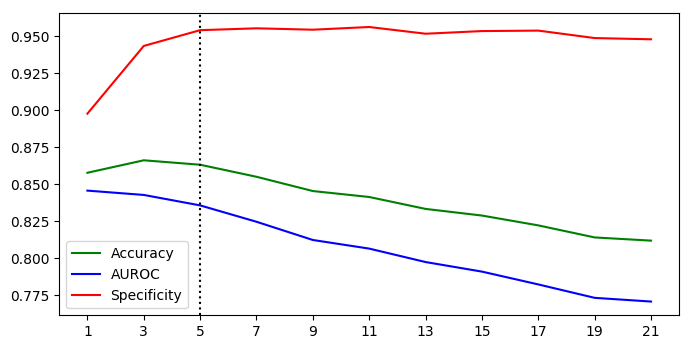

In [173]:
from matplotlib import pyplot as plt

accs, aurocs, specifs = mean_res[:, 0], mean_res[:, 1], mean_res[:, 2]

plt.figure(figsize=(8, 4), dpi=100)
plt.xticks(np.arange(1, 22, 2))
plt.legend(handles=[acc_line, auroc_line, specif_line])

acc_line,  = plt.plot(n_neighbors, accs, color='green', label='Accuracy')
auroc_line,  = plt.plot(n_neighbors, aurocs, color='blue', label='AUROC')
specif_line,  = plt.plot(n_neighbors, specifs, color='red', label='Specificity')
plt.axvline(x=5, color='black', linestyle=':')

plt.show()

From the figure above, we can see that the drop in accuracy and AUROC is not significant from $n = 1$ to $n = 5$ (less than 1% for accuracy and less than 1.5% for AUROC), but the increase in specificity (which we care about) is quite drastic (more than 5%). Thus, trading off AUROC for better type I error handling is worth it since the gain from making fewer false positives in practicality is more valuable (again, we would rather say that a person cannot get a loan than if we say he/she can but they end up not getting it). 

After $n=5$ the out-of-sample accuracy stars to plummet indicating that we are overfitting the data (or, in other words, being biased by a more dense distribution of neighbors).

Therefore, from our empirical analysis, we choose the classifier with 5 nearest neighbors.

## Part 4: Prediction and evaluation
**Step 1**: Now let's run cross-validation for the full dataset and get an estimate of its test-set performance. This time we will run with more folds to an estimate get closer to the LOOCV estimate that is performed on almost all training data, thus, giving a more precise estimate of test set error).

In [185]:
fin_eval = eval_models(data_norm, targets, n_neighbors=[5], n_splits=10)

Iteration 1 out of 1 | Evaluating n_neighbors = 5 | K-fold iteration 1 2 3 4 5 6 7 8 9 10 


*This takes very long (about 30 mins), so think twice before you run it ^_^

In [187]:
mean_eval = np.mean(fin_eval, axis=1)[0]
print("Estimated test set accuracy:", mean_eval[0])
print("Estimated test set AUROC:", mean_eval[1])
print("Estimated test set specificity:", mean_eval[2])

Estimated test set accuracy: 0.9300735209369133
Estimated test set AUROC: 0.9127939790234256
Estimated test set specificity: 0.9895677226150349


Wow, specificity of 98.96%. This is good stuff! 

**Step 2**: Build a wrapper function that predicts whether a person will get a loan or not. If amount requested is not inputted, the function will try to optimize for the highest amount that can be requested that is still "acceptable." For employment length, we will consider 5 years as the average (since "10+" years is not quantifiable). State will be required since each state has different policies so the answer could vary much and we cannot have an "average" state. If any other feature is not provided, we will take the mean of all available data for that feature.

In [61]:
import numpy as np

def loan_qualify(clf,
                 state,
                 amt_requested=None,
                 app_date=means['Application Date'],
                 dti=means['Debt-To-Income Ratio'],
                 emp_len=5):
    
    query = pd.DataFrame(np.zeros((1, len(list(data)))), columns=list(data))
    query.at[0, 'Application Date'] = float((dt.strptime(app_date, '%Y-%m-%d').timestamp() -
                                    means['Application Date']) / stds['Application Date'])
    query.at[0, 'Debt-To-Income Ratio'] = (dti - means['Debt-To-Income Ratio']) / stds['Debt-To-Income Ratio']
    query.at[0, state] = (1 - means[state]) / stds[state]
    
    if emp_len >= 10:
        emp_len = '10+ years'
    elif emp_len <= 1:
        emp_len = '< 1 year'
    else:
        emp_len = str(int(emp_len)) + " years"
    
    query.at[0, emp_len] = (1 - means[emp_len]) / stds[emp_len]
    
    if amt_requested != None:
        query.at[0, 'Amount Requested'] = (amt_requested - means['Amount Requested']) / stds['Amount Requested']
        pred = clf.predict(query)
        return pred[0]
    
    else:
        loan_amt = 0
        query.at[0, 'Amount Requested'] = (loan_amt - means['Amount Requested']) / stds['Amount Requested']
        
        while clf.predict(query)[0] == 1:
            loan_amt += 1000 # incremental steps of 100 dollars until cannot loan anymore
            query.at[0, 'Amount Requested'] = (loan_amt - means['Amount Requested']) / stds['Amount Requested']
        
        if loan_amt > 0:
            loan_amt -= 1000 # revert to the last "acceptable" loan
        return loan_amt

**Step 3**: Build a 5-NN classifier to predict on new data

In [32]:
loan_clf = KNeighborsClassifier(n_neighbors=5)
loan_clf.fit(data_norm, targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

*Scenario 1*: All inputs available. Client knows how much he/she wants to loan and wants to check if it's possible to loan that amount given the conditions

In [33]:
if loan_qualify(loan_clf, 'CA', 20000, '2012-02-13', 10, emp_len=5) == 1:
    print("Congratulations, you're most likely qualified for this loan!")
else:
    print("Unfortunately, you risk getting a rejection for this loan.")

Congratulations, you're most likely qualified for this loan!


In [97]:
if loan_qualify(loan_clf, 'CA', 20000, '2007-02-13', 10, 5) == 1:
    print("Congratulations, you're most likely qualified for this loan!")
else:
    print("Unfortunately, you risk getting a rejection for this loan.")

Unfortunately, you risk getting a rejection for this loan.


In the crisis times, the same person would not likely receive a loan.

*Scenario 2*: Amount not given. The client wants to know how much maximum he/she can loan.

In [98]:
print("The largest loan you can possibly get: ",
      loan_qualify(loan_clf, app_date='2007-10-10', state='AZ', dti=100, emp_len=0))

The largest loan you can possibly get:  0


**Step 4**: We will now plot our decision boundary and the actual data to see how well our model works and where are its pitfalls

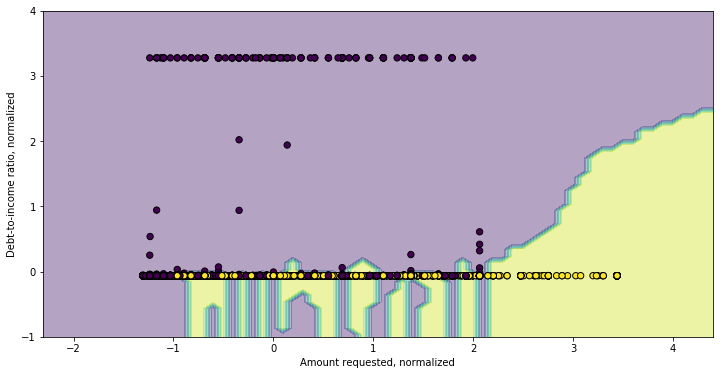

In [57]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_sub.loc[:, ['Amount Requested', 'Debt-To-Income Ratio']], y_sub)

# Plotting decision regions
x1_min, x1_max = X_sub['Amount Requested'].min() - 1, X_sub['Amount Requested'].max() + 1
x2_min, x2_max = X_sub['Debt-To-Income Ratio'].min() - 1, X_sub['Debt-To-Income Ratio'].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                       np.arange(x2_min, x2_max, 0.1))

for clf, tt in [(clf, 'KNN (k=5)')]:
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    plt.figure(figsize=(12, 6))
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    plt.ylim(-1, 4)
    plt.xlabel('Amount requested, normalized')
    plt.ylabel('Debt-to-income ratio, normalized')
    plt.scatter(X_sub['Amount Requested'], X_sub['Debt-To-Income Ratio'], c=y_sub,
                                  s=40, edgecolor='k')

plt.show()

The above plot is the same kNN trained on amount requested and DTI. Purple shows the region acceptable loans and the yellow shows the region of rejectable loans. We can see that as debt-to-ratio increases, there needs to be a higher amount requested (e.g., if someone is lending only $100, and it causes your dti to be 90% then there's something wrong). We can also see that generally the class that has lower DTI is more likely to get a loan approved, whereas the class which has high DTI is unlikely to be approved.

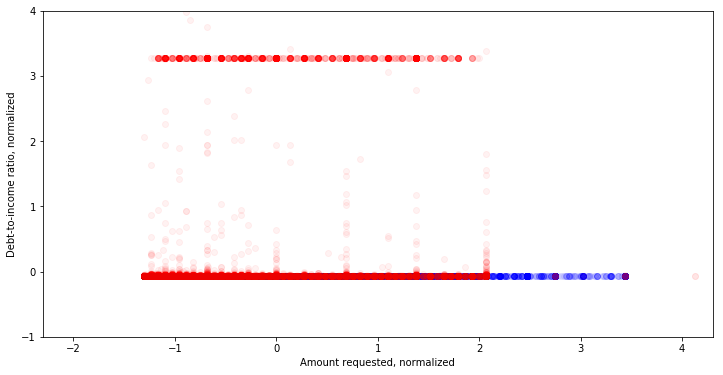

In [103]:
acc_idx = targets.index[targets == 1].tolist()
rej_idx = targets.index[targets == 0].tolist()

plt.figure(figsize=(12, 6))
plt.xlabel('Amount requested, normalized')
plt.ylim(-1, 4)
plt.xlim(-2.3, 4.3) # to look like plot above
plt.ylabel('Debt-to-income ratio, normalized')

plt.scatter(data_norm['Amount Requested'][acc_idx], data_norm['Debt-To-Income Ratio'][acc_idx], color="blue", alpha=0.05)
plt.scatter(data_norm['Amount Requested'][rej_idx], data_norm['Debt-To-Income Ratio'][rej_idx], color="red", alpha=0.05)
plt.show()

This is actual data, normalized. Red dots mean rejection, while blue dots mean acceptance. We can observe the similar behavior as in the decision boundary analysis above.

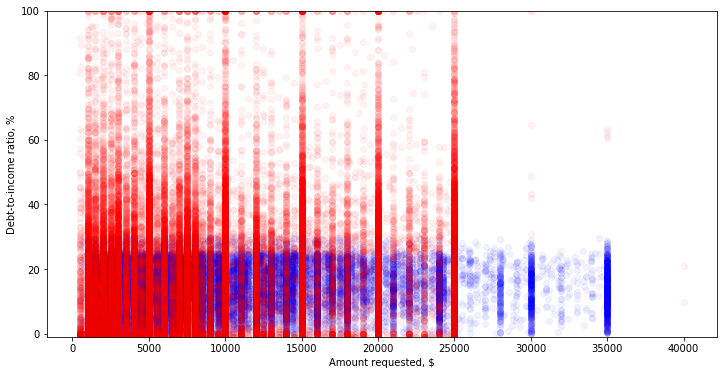

In [100]:
restored_data = data_norm * stds + means

plt.figure(figsize=(12, 6))
plt.xlabel('Amount requested, $')
plt.ylim(-1, 100)
plt.ylabel('Debt-to-income ratio, %')

plt.scatter(restored_data['Amount Requested'][acc_idx], restored_data['Debt-To-Income Ratio'][acc_idx], color="blue", alpha=0.05)
plt.scatter(restored_data['Amount Requested'][rej_idx], restored_data['Debt-To-Income Ratio'][rej_idx], color="red", alpha=0.05)
plt.show()

This plot is the actual responses in the original dataset. We can see a similar tendency as in our predicted model. If we have a high DTI, then it better be because of the amount the requested is large enough (e.g., 12,000). After a certain level of DTI, there is almost no acceptance. Also, we can see that this dataset might not be too good for predicting loan amounts larger than 25,000 since these people most likely have substantial reasons (e.g., in features we did not extract like loan title, description of loan usage), so they do or do not get rejected based on that. In our kNN case based on other features, high requested amounts are just straightforward "accepted" since we do not have a good classification criterion there.